# Base Model Training

setup dataloaders, loss, optimizer, execute training loop, output curves to tensorboard, view results via tensorboard

In [1]:
import os
import shutil
from tqdm import tqdm
from pathlib import Path
import time
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import ntpath
import collections
import shutil

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

/home/jared/miniconda3/envs/speed_detection/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import sys
sys.path.append('../')

from source.custom_transforms import (open_image_from_path, constructMask, Crop, GaussianBlur, RandomBrightness, 
                                      opticalFlowDense, RICAP, ToTensor, ToNumpy)

%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = Path('../data/').resolve()
TRAIN_VIDEO = DATA_PATH/'train.mp4'
TEST_VIDEO = DATA_PATH/'test.mp4'
CLEAN_DATA_PATH = Path('../data/').resolve()

TRAIN_PATH = DATA_PATH/'train'
VAL_PATH = DATA_PATH/'val'
TEST_PATH = DATA_PATH/'test'
HOLDOUT_PATH = DATA_PATH/'holdout'

MODEL_PATH = Path('../models/').resolve()

# Training Parameters

In [4]:
seed = 42

# hyperparameters
batch_size = 5*torch.cuda.device_count()
num_epochs = 50 #100 #90

# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# Loading Meta dataset

In [5]:
train_meta = pd.read_csv(TRAIN_PATH/'train_meta.csv')
print('shape: ', train_meta.shape)
val_meta = pd.read_csv(VAL_PATH/'val_meta.csv')
print('shape: ', val_meta.shape)
holdout_meta = pd.read_csv(HOLDOUT_PATH/'holdout_meta.csv')
print('shape: ', holdout_meta.shape)

shape:  (14280, 3)
shape:  (4080, 3)
shape:  (2040, 3)


In [6]:
train_ids = train_meta['image_index'].values
val_ids = val_meta['image_index'].values
holdout_ids = holdout_meta['image_index'].values

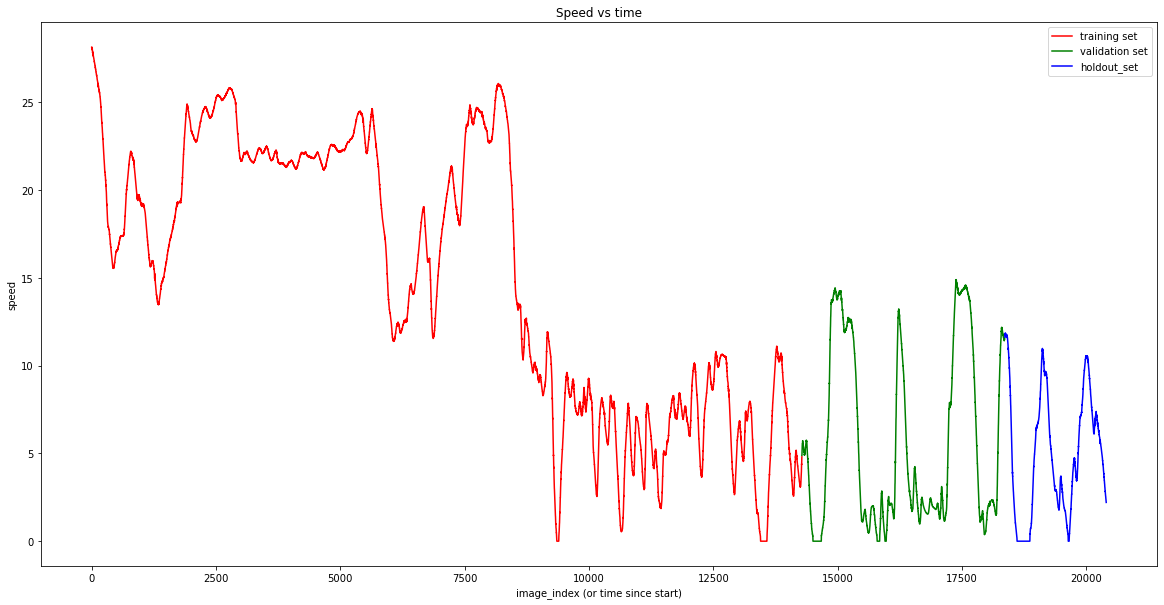

----
train_data:  14280
valid_data:  4080
holdout_data:  2040


In [7]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_ids, train_meta['speed'], 'r')
plt.plot(val_ids, val_meta['speed'], 'g')
plt.plot(holdout_ids, holdout_meta['speed'], 'b')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set', 'holdout_set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('train_data: ', len(train_ids))
print('valid_data: ', len(val_ids))
print('holdout_data: ', len(holdout_ids))

# Data setup: transformations, Dataset, Dataloader

In [8]:
ricap = RICAP(0.4, (0.2, 0.4))
totensor = ToTensor(dtype)

In [9]:
class OpticalFlowDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, overwrite_flow, pre_flow_transforms=None, post_flow_transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to create flow_images folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.flow_dir = root_dir/"flow_images"
        self.overwrite_flow = overwrite_flow
        self.pre_transform = pre_flow_transforms
        self.post_transforms = post_flow_transforms
        self.mask = constructMask(640, 480)
        
        self._make_flow(csv_file);
        
    def _make_flow(self, csv_file):
        os.makedirs(self.flow_dir, exist_ok=True)
        if(self.overwrite_flow == False):
            new_df = pd.read_csv(self.root_dir/f'{str(csv_file)[:-4]}_flow.csv')
            
            cur_flow = [f for f in os.listdir(self.flow_dir) if f.endswith('.jpg')]
            flow_paths = new_df['flow_path'].apply(ntpath.basename).values
            
            if collections.Counter(self.df['image_path'].values[:-1]) != collections.Counter(new_df['image_path'].values):
                raise ValueError("Overwrite set to false, but old and new dataframe do not match")
            if collections.Counter(cur_flow) != collections.Counter(flow_paths):
                raise ValueError("Overwrite set to false, but Dataframe and current images saved do not match")
 
            self.df = new_df
            return
        
        #delete all files
        all_paths = [os.path.join(self.flow_dir, f) for f in os.listdir(self.flow_dir) if f.endswith(".jpg") ]
        for f in all_paths:
            os.remove(f)
    
        names = []
        for idx in range(0, self.df.shape[0]-1):
            sample = self._get_frames(idx)

            #get rgb flow
            flow = opticalFlowDense(sample['frame1'], sample['frame2'])
            #flow[self.mask == 0] = 0

            #save as rgb
            basename = ntpath.basename(sample['frame1_name'])
            save_path = str(self.flow_dir/basename)
            cv2.imwrite(save_path, flow)
            names += [save_path]
        
        #remove last frame from dataset, flow does not exist here
        self.df.drop(self.df.tail(1).index,inplace=True)
    
        #save paths to df
        self.df['flow_path'] = names
        csv_name = ntpath.basename(csv_file)
        self.df.to_csv(self.root_dir/f'{str(csv_file)[:-4]}_flow.csv', index=False)

    def __len__(self):
        return len(self.df)

    def _get_frames(self, idx):
        """
        returns the frames used to consturct the flow for a given index
        
        (i),(i+1) used to calculate flow for index i
        """
        frame1_name = self.df.iloc[idx]['image_path']
        frame2_name = self.df.iloc[idx+1]['image_path']

        frame1 = open_image_from_path(frame1_name)
        frame2 = open_image_from_path(frame2_name)
                   
        sample = {'frame1_name': frame1_name, 'frame1': frame1, 
                  'frame2_name': frame2_name, 'frame2': frame2}
        
        if self.pre_transform:
            sample = self.pre_transform(sample)
            
        return sample
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #read in rgb
        sample = {'image': cv2.imread(self.df['flow_path'].values[idx]),
                  'speed': self.df['speed'].values[idx]}

        if self.post_transforms:
            sample['image'] = self.post_transforms(sample['image'])
            sample['speed'] = torch.tensor(sample['speed']).type(dtype)
        
        return sample

#### initializing dataset

In [10]:
#calc normalization values
calc_norm = True

if calc_norm:
    print('constructing train flow dataset')
    train_flow = OpticalFlowDataset(TRAIN_PATH/'train_meta.csv', 
                                TRAIN_PATH,
                                overwrite_flow = True,
                                pre_flow_transforms = transforms.Compose([Crop()]),
                                post_flow_transforms = transforms.Compose([totensor
                                                                          ])
                               )
    
    train_dataloader = DataLoader(train_flow, batch_size=batch_size, shuffle=True, num_workers=0)
    
    print('constructing val flow dataset')
    val_flow = OpticalFlowDataset(VAL_PATH/'val_meta.csv', 
                              VAL_PATH,
                              overwrite_flow = False,
                              pre_flow_transforms = transforms.Compose([Crop()]),
                              post_flow_transforms = transforms.Compose([totensor
                                                                        ])
                             )
    

    print('computing normalization values from training dataset')
    #computing normalization values:
    pop_mean = []
    pop_std0 = []
    pop_std1 = []
    for i, data in enumerate(train_dataloader, 0):
        # shape (batch_size, 3, height, width)
        if device.type == 'cuda':
            numpy_image = data['image'].cpu().numpy()
        else:
            numpy_image = data['image'].numpy()

        # shape (3,)
        batch_mean = np.mean(numpy_image, axis=(0,2,3))
        batch_std0 = np.std(numpy_image, axis=(0,2,3))
        batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

        pop_mean.append(batch_mean)
        pop_std0.append(batch_std0)
        pop_std1.append(batch_std1)

    # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
    normalize_vals = [list(np.array(pop_mean).mean(axis=0)),
                   list(np.array(pop_std0).mean(axis=0))] 
    
    print('mean;std0;std1')
    print(normalize_vals[0], '', sep=', ')
    print(normalize_vals[1], '', sep=', ')
    print(list(np.array(pop_std1).mean(axis=0)), sep=', ')

constructing train flow dataset
constructing val flow dataset
computing normalization values from training dataset
mean;std0;std1
[10.97697, 7.8774333, 6.815209], 
[28.750046, 23.953611, 18.066048], 
[28.750046, 23.953617, 18.066051]


In [11]:
#copy the printed values and save them to skip normalize calculations:
if not calc_norm:
    print('mean;std0;std1')
    all_vals = [[9.57483, 7.217421, 5.485012], 
                [23.724548, 20.464907, 14.464276], 
                [23.724558, 20.464909, 14.464279]]

    normalize_vals = all_vals[0:2]
    for val in all_vals:
        print(val)

In [12]:
print("Initializing Datasets and Dataloaders...")
    
train_flow = OpticalFlowDataset(TRAIN_PATH/'train_meta.csv', 
                                TRAIN_PATH,
                                overwrite_flow = False,
                                pre_flow_transforms = transforms.Compose([Crop()]),
                                post_flow_transforms = transforms.Compose([totensor, 
                                                                           transforms.Normalize(normalize_vals[0], 
                                                                                                normalize_vals[1])
                                                                          ])
                               )
                        

train_dataloader = DataLoader(train_flow, batch_size=batch_size, shuffle=True, num_workers=0)
print('train initialized')

val_flow = OpticalFlowDataset(VAL_PATH/'val_meta.csv', 
                              VAL_PATH,
                              overwrite_flow = False,
                              pre_flow_transforms = transforms.Compose([Crop()]),
                              post_flow_transforms = transforms.Compose([totensor,
                                                                         transforms.Normalize(normalize_vals[0],
                                                                                              normalize_vals[1])
                                                                        ])
                             )

val_dataloader = DataLoader(val_flow, batch_size=batch_size, shuffle=False, num_workers=0)
print('val initialized')

Initializing Datasets and Dataloaders...
train initialized
val initialized


#### visualizing flow

0 torch.Size([20, 3, 220, 570]) torch.Size([20])
1 torch.Size([20, 3, 220, 570]) torch.Size([20])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([20, 3, 220, 570]) torch.Size([20])
3 torch.Size([20, 3, 220, 570]) torch.Size([20])


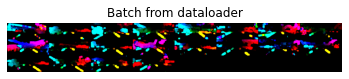

In [13]:
# Helper function to show a batch
def show_flow(images_batched):
    """Show image with landmarks for a batch of samples."""
    im_size = images_batched.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

for i_batch, data in enumerate(train_dataloader):
    if device.type == 'cuda':
        data['image'] = data['image'].cpu()
        data['speed'] = data['speed'].cpu()
        
    print(i_batch, data['image'].size(),
          data['speed'].size())
    
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_flow(data['image'])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

#### Before and after

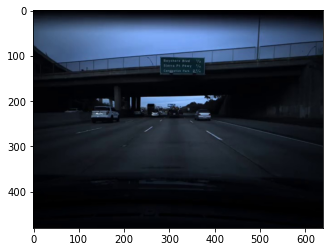

In [14]:
temp = cv2.imread(train_flow.df.iloc[0]['image_path'])

plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))

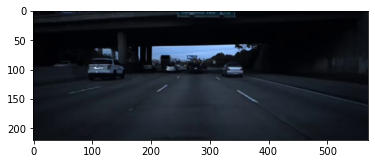

In [15]:
sample = train_flow._get_frames(0)
plt.imshow(sample['frame1'])

#### iterating through model inputs

In [16]:
it = iter(train_flow)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


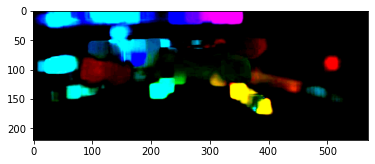

In [17]:
plt.axis('off')
plt.imshow(ToNumpy()(next(it)['image']))

# Training Setup: Model, Optimizer, Loss, Epochs, TensorBoard


In [18]:
# run specific constants
model_name = 'efficientnet-b4'
run_name = '{}-batch={}-epochs={}'.format(model_name,batch_size, num_epochs)

model_filepath = os.path.join(MODEL_PATH, run_name)
os.makedirs(model_filepath, exist_ok=True)
tensorboard_loc = os.path.join(model_filepath, 'tensorboard')
writer = SummaryWriter(tensorboard_loc)
shutil.copyfile('dense_flow_deep_learning.ipynb', os.path.join(model_filepath, 'nb_backup.ipynb'))

'/home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/nb_backup.ipynb'

In [19]:
#model = EfficientNet.from_pretrained(f'{model_name}')
model = EfficientNet.from_name(f'{model_name}')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)
model._dropout = nn.Dropout(p=0.6, inplace=False)

start_epoch = 0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

if device.type == 'cuda':
    if torch.cuda.device_count() > 1:
        gpu_ids = list(range(torch.cuda.device_count()))
        model = nn.DataParallel(model, device_ids=gpu_ids)

for param in model.parameters():
    param.requires_grad = True
        
model.to(device)

DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

In [20]:
load_checkpoint = False

if load_checkpoint == True:
    print('loading checkpoint')
    #change to your model checkpoint loc
    checkpoint_path = Path("../models/efficientnet-b4-batch=20-epochs=50/model_48.pt").resolve()
    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']

# PyTorch Training Loop

In [21]:
train_log_iters = len(train_dataloader) // 40
val_log_iters = len(train_dataloader) // 3

print(f'Number of epochs: {num_epochs}')
print(f'Batches per epoch: {len(train_dataloader)}')
print(f'train logging frequency: {train_log_iters}')
print(f'validation logging frequency: {val_log_iters}')

Number of epochs: 50
Batches per epoch: 714
train logging frequency: 17
validation logging frequency: 238


In [22]:
train = True

if train == True:
    print(f'Batches per epoch: {len(train_dataloader)}')
    epoch_loss = None
    
    
    for epoch in range(start_epoch, num_epochs):  # loop over the dataset multiple times
        """
        Start new epoch
        """
        print(f'-----------------starting epoch {epoch}-----------------')
        full_running_loss = 0.0
        running_loss = 0.0
        model.train()

        for i, data in enumerate(train_dataloader, 0):
            """
            Batch operations
            """
            torch.cuda.synchronize()
            since = int(round(time.time()*1000))

            # get the inputs; data is a dict
            inputs = data['image']
            labels = data['speed']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.reshape(outputs.size()[0])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            full_running_loss += loss.item()

            time_elapsed = int(round(time.time()*1000)) - since
            writer.add_scalar('WallTime/Train Batch (ms)', time_elapsed, epoch * len(train_dataloader) + i) 

            #print(running_loss)

            """
            Train metrics logging
            """
            if i % train_log_iters == train_log_iters - 1:    # every train_log_iters mini-batches... 
                # log the running loss
                writer.add_scalar(f'Loss/Train MSE, {train_log_iters} batches',
                                running_loss / train_log_iters,
                                epoch * len(train_dataloader) + i)    

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                '''writer.add_figure('predictions vs. actuals',
                                plot_classes_preds(net, inputs, labels),
                                global_step=epoch * len(trainloader) + i)'''


                print(f'batch {i}, train loss: {running_loss}, wall time: {time_elapsed} ms')
                running_loss = 0.0

            """
            Val metrics logging
            """
            if i % val_log_iters == val_log_iters - 1:    # every val_log_iters mini-batches...
                torch.cuda.synchronize()
                since = int(round(time.time()))

                #get validation loss:
                model.eval()
                val_loss = 0.0
                for j, data in enumerate(val_dataloader, 0):
                    with torch.no_grad():
                        inputs = data['image']
                        labels = data['speed']

                        # forward + backward + optimize
                        outputs = model(inputs)
                        outputs = outputs.reshape(outputs.size()[0])
                        loss = criterion(outputs, labels)

                        val_loss += loss.item()

                val_loss = val_loss / len(val_dataloader)
                # log the validation loss
                writer.add_scalar('Loss/Validation MSE',
                                  val_loss,
                                  epoch * len(train_dataloader) + i)

                time_elapsed = int(round(time.time())) - since
                writer.add_scalar('WallTime/Validation Set (s)', time_elapsed, epoch * len(train_dataloader) + i) 

                model.train()
                print(f'** validation MSE: {val_loss}, wall time: {time_elapsed} s**')

        """
        End of Epoch
        """
        if epoch_loss == None or full_running_loss < epoch_loss:
            epoch_loss  = full_running_loss
            checkpoint_path = os.path.join(model_filepath, f'model_{epoch}.pt')
            print(f'saving checkpoint as: {checkpoint_path}')
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': full_running_loss,
                        'val_loss': val_loss,
                        }, checkpoint_path)

        full_running_loss = full_running_loss / len(train_dataloader)
        writer.add_scalar(f'Epoch Loss/Train MSE', full_running_loss, epoch)    
        writer.add_scalar(f'Epoch Loss/Val MSE', val_loss, epoch)    
        
        full_running_loss = 0
    print('Finished Training')
    writer.close()

Batches per epoch: 714
-----------------starting epoch 0-----------------
batch 16, train loss: 3420.5167541503906, wall time: 206 ms
batch 33, train loss: 1682.6185760498047, wall time: 265 ms
batch 50, train loss: 838.0899772644043, wall time: 206 ms
batch 67, train loss: 745.7912178039551, wall time: 207 ms
batch 84, train loss: 793.8876113891602, wall time: 206 ms
batch 101, train loss: 647.5314235687256, wall time: 205 ms
batch 118, train loss: 532.0655450820923, wall time: 208 ms
batch 135, train loss: 532.6188459396362, wall time: 266 ms
batch 152, train loss: 479.1314449310303, wall time: 203 ms
batch 169, train loss: 420.4740810394287, wall time: 209 ms
batch 186, train loss: 385.39919662475586, wall time: 208 ms
batch 203, train loss: 408.87314891815186, wall time: 205 ms
batch 220, train loss: 468.6119794845581, wall time: 206 ms
batch 237, train loss: 393.4740719795227, wall time: 266 ms
** validation MSE: 26.325252109650048, wall time: 26 s**
batch 254, train loss: 328.577

batch 662, train loss: 132.4177167415619, wall time: 210 ms
batch 679, train loss: 97.48727369308472, wall time: 208 ms
batch 696, train loss: 75.72260415554047, wall time: 267 ms
batch 713, train loss: 72.73330426216125, wall time: 210 ms
** validation MSE: 75.28671716825635, wall time: 26 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/model_2.pt
-----------------starting epoch 3-----------------
batch 16, train loss: 53.99458646774292, wall time: 268 ms
batch 33, train loss: 50.81722044944763, wall time: 208 ms
batch 50, train loss: 51.20568776130676, wall time: 208 ms
batch 67, train loss: 45.14318263530731, wall time: 210 ms
batch 84, train loss: 40.27790743112564, wall time: 209 ms
batch 101, train loss: 53.84290015697479, wall time: 205 ms
batch 118, train loss: 46.411593556404114, wall time: 269 ms
batch 135, train loss: 45.35552251338959, wall time: 209 ms
batch 152, train loss: 45.77892053127289, wall time: 209 ms
batch

batch 560, train loss: 21.540833115577698, wall time: 206 ms
batch 577, train loss: 23.19550096988678, wall time: 211 ms
batch 594, train loss: 18.32780522108078, wall time: 270 ms
batch 611, train loss: 19.942057251930237, wall time: 213 ms
batch 628, train loss: 19.825263381004333, wall time: 208 ms
batch 645, train loss: 20.0578173995018, wall time: 209 ms
batch 662, train loss: 24.706533133983612, wall time: 207 ms
batch 679, train loss: 24.944365441799164, wall time: 206 ms
batch 696, train loss: 40.234403014183044, wall time: 268 ms
batch 713, train loss: 35.085588693618774, wall time: 209 ms
** validation MSE: 61.86029567905501, wall time: 26 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/model_5.pt
-----------------starting epoch 6-----------------
batch 16, train loss: 34.78200423717499, wall time: 268 ms
batch 33, train loss: 29.40342080593109, wall time: 210 ms
batch 50, train loss: 29.938234090805054, wall time: 215 

** validation MSE: 77.9922111770686, wall time: 26 s**
batch 492, train loss: 18.528236538171768, wall time: 209 ms
batch 509, train loss: 14.090874582529068, wall time: 211 ms
batch 526, train loss: 16.154851615428925, wall time: 209 ms
batch 543, train loss: 18.475401997566223, wall time: 211 ms
batch 560, train loss: 15.446007192134857, wall time: 208 ms
batch 577, train loss: 19.294201016426086, wall time: 284 ms
batch 594, train loss: 17.60852935910225, wall time: 211 ms
batch 611, train loss: 20.77859526872635, wall time: 209 ms
batch 628, train loss: 18.12263235449791, wall time: 210 ms
batch 645, train loss: 18.584490180015564, wall time: 212 ms
batch 662, train loss: 20.372766077518463, wall time: 208 ms
batch 679, train loss: 12.889534890651703, wall time: 270 ms
batch 696, train loss: 16.623371601104736, wall time: 210 ms
batch 713, train loss: 16.012227207422256, wall time: 207 ms
** validation MSE: 48.171997478195266, wall time: 26 s**
-----------------starting epoch 9----

batch 441, train loss: 19.550533950328827, wall time: 271 ms
batch 458, train loss: 17.619715362787247, wall time: 210 ms
batch 475, train loss: 15.70288473367691, wall time: 207 ms
** validation MSE: 69.37126406209141, wall time: 26 s**
batch 492, train loss: 15.236228823661804, wall time: 272 ms
batch 509, train loss: 16.26590469479561, wall time: 210 ms
batch 526, train loss: 16.308779537677765, wall time: 208 ms
batch 543, train loss: 15.705774009227753, wall time: 206 ms
batch 560, train loss: 15.227177292108536, wall time: 210 ms
batch 577, train loss: 15.821804970502853, wall time: 271 ms
batch 594, train loss: 16.822880268096924, wall time: 270 ms
batch 611, train loss: 14.504726737737656, wall time: 210 ms
batch 628, train loss: 15.773858904838562, wall time: 209 ms
batch 645, train loss: 13.57949049770832, wall time: 212 ms
batch 662, train loss: 13.741147309541702, wall time: 211 ms
batch 679, train loss: 14.312069594860077, wall time: 269 ms
batch 696, train loss: 12.437155

batch 356, train loss: 12.157767623662949, wall time: 209 ms
batch 373, train loss: 9.665508016943932, wall time: 222 ms
batch 390, train loss: 9.470950335264206, wall time: 210 ms
batch 407, train loss: 9.570628270506859, wall time: 213 ms
batch 424, train loss: 10.631294250488281, wall time: 270 ms
batch 441, train loss: 11.84661865234375, wall time: 271 ms
batch 458, train loss: 17.87802302837372, wall time: 211 ms
batch 475, train loss: 10.68894374370575, wall time: 214 ms
** validation MSE: 96.61906781967949, wall time: 26 s**
batch 492, train loss: 12.1074148863554, wall time: 279 ms
batch 509, train loss: 10.914600998163223, wall time: 209 ms
batch 526, train loss: 11.770058751106262, wall time: 211 ms
batch 543, train loss: 13.614461660385132, wall time: 210 ms
batch 560, train loss: 10.100914090871811, wall time: 212 ms
batch 577, train loss: 12.094357758760452, wall time: 269 ms
batch 594, train loss: 11.295836210250854, wall time: 212 ms
batch 611, train loss: 12.55269894003

batch 339, train loss: 9.809503048658371, wall time: 249 ms
batch 356, train loss: 9.909261971712112, wall time: 267 ms
batch 373, train loss: 10.347698390483856, wall time: 211 ms
batch 390, train loss: 7.735057979822159, wall time: 209 ms
batch 407, train loss: 8.29050087928772, wall time: 213 ms
batch 424, train loss: 9.752495795488358, wall time: 210 ms
batch 441, train loss: 8.752902135252953, wall time: 269 ms
batch 458, train loss: 11.687496274709702, wall time: 275 ms
batch 475, train loss: 10.55566531419754, wall time: 209 ms
** validation MSE: 64.58304952114236, wall time: 26 s**
batch 492, train loss: 10.636854097247124, wall time: 272 ms
batch 509, train loss: 9.351091265678406, wall time: 270 ms
batch 526, train loss: 8.913416296243668, wall time: 212 ms
batch 543, train loss: 8.785195976495743, wall time: 211 ms
batch 560, train loss: 9.523858815431595, wall time: 211 ms
batch 577, train loss: 8.97962537407875, wall time: 208 ms
batch 594, train loss: 8.354617431759834, w

batch 271, train loss: 14.51790851354599, wall time: 268 ms
batch 288, train loss: 15.541739881038666, wall time: 212 ms
batch 305, train loss: 16.29018262028694, wall time: 211 ms
batch 322, train loss: 13.532088726758957, wall time: 211 ms
batch 339, train loss: 13.015604227781296, wall time: 210 ms
batch 356, train loss: 16.49505779147148, wall time: 274 ms
batch 373, train loss: 13.34167206287384, wall time: 269 ms
batch 390, train loss: 11.699061453342438, wall time: 208 ms
batch 407, train loss: 11.695104420185089, wall time: 211 ms
batch 424, train loss: 10.265633583068848, wall time: 208 ms
batch 441, train loss: 12.141840636730194, wall time: 212 ms
batch 458, train loss: 11.74866384267807, wall time: 273 ms
batch 475, train loss: 10.842747822403908, wall time: 270 ms
** validation MSE: 68.79643282411145, wall time: 26 s**
batch 492, train loss: 11.809538632631302, wall time: 216 ms
batch 509, train loss: 12.634147852659225, wall time: 272 ms
batch 526, train loss: 11.94122141

batch 254, train loss: 7.485015258193016, wall time: 208 ms
batch 271, train loss: 8.02735260128975, wall time: 209 ms
batch 288, train loss: 8.235930293798447, wall time: 270 ms
batch 305, train loss: 8.23323766887188, wall time: 210 ms
batch 322, train loss: 9.867232993245125, wall time: 209 ms
batch 339, train loss: 8.05971023440361, wall time: 211 ms
batch 356, train loss: 10.531143456697464, wall time: 210 ms
batch 373, train loss: 8.329553291201591, wall time: 206 ms
batch 390, train loss: 6.696531891822815, wall time: 269 ms
batch 407, train loss: 8.96423327922821, wall time: 213 ms
batch 424, train loss: 8.319777756929398, wall time: 211 ms
batch 441, train loss: 7.361737504601479, wall time: 208 ms
batch 458, train loss: 9.21701779961586, wall time: 209 ms
batch 475, train loss: 8.21114695072174, wall time: 213 ms
** validation MSE: 71.65574158523597, wall time: 26 s**
batch 492, train loss: 8.025655642151833, wall time: 210 ms
batch 509, train loss: 7.020789921283722, wall ti

batch 186, train loss: 7.371834933757782, wall time: 208 ms
batch 203, train loss: 6.624531239271164, wall time: 212 ms
batch 220, train loss: 9.735959976911545, wall time: 245 ms
batch 237, train loss: 5.6551196947693825, wall time: 271 ms
** validation MSE: 60.6124556232609, wall time: 26 s**
batch 254, train loss: 8.06380158662796, wall time: 211 ms
batch 271, train loss: 7.290838524699211, wall time: 242 ms
batch 288, train loss: 7.36332830786705, wall time: 271 ms
batch 305, train loss: 8.422813832759857, wall time: 210 ms
batch 322, train loss: 8.216275408864021, wall time: 213 ms
batch 339, train loss: 7.776926249265671, wall time: 210 ms
batch 356, train loss: 6.826166406273842, wall time: 211 ms
batch 373, train loss: 7.7196671813726425, wall time: 244 ms
batch 390, train loss: 7.3215189427137375, wall time: 275 ms
batch 407, train loss: 7.168445989489555, wall time: 209 ms
batch 424, train loss: 8.111096203327179, wall time: 209 ms
batch 441, train loss: 6.06078927218914, wal

batch 186, train loss: 10.204154282808304, wall time: 211 ms
batch 203, train loss: 9.04332460463047, wall time: 212 ms
batch 220, train loss: 9.228303268551826, wall time: 210 ms
batch 237, train loss: 10.356869399547577, wall time: 211 ms
** validation MSE: 82.69875587961253, wall time: 26 s**
batch 254, train loss: 10.56013485789299, wall time: 211 ms
batch 271, train loss: 9.115479096770287, wall time: 207 ms
batch 288, train loss: 8.811027348041534, wall time: 211 ms
batch 305, train loss: 9.498776525259018, wall time: 270 ms
batch 322, train loss: 7.640070587396622, wall time: 210 ms
batch 339, train loss: 10.603544399142265, wall time: 213 ms
batch 356, train loss: 8.459683075547218, wall time: 211 ms
batch 373, train loss: 7.894201457500458, wall time: 212 ms
batch 390, train loss: 8.19165426492691, wall time: 214 ms
batch 407, train loss: 8.77089536190033, wall time: 289 ms
batch 424, train loss: 8.310304343700409, wall time: 210 ms
batch 441, train loss: 7.306831449270248, wa

batch 135, train loss: 7.337094649672508, wall time: 212 ms
batch 152, train loss: 6.646017007529736, wall time: 215 ms
batch 169, train loss: 6.5060494393110275, wall time: 268 ms
batch 186, train loss: 5.983886659145355, wall time: 210 ms
batch 203, train loss: 7.523157641291618, wall time: 212 ms
batch 220, train loss: 6.4407903999090195, wall time: 211 ms
batch 237, train loss: 6.779129445552826, wall time: 213 ms
** validation MSE: 75.64845049615, wall time: 26 s**
batch 254, train loss: 7.782899349927902, wall time: 215 ms
batch 271, train loss: 9.312673926353455, wall time: 210 ms
batch 288, train loss: 8.669674336910248, wall time: 209 ms
batch 305, train loss: 7.649701356887817, wall time: 254 ms
batch 322, train loss: 7.167160466313362, wall time: 271 ms
batch 339, train loss: 6.172975584864616, wall time: 216 ms
batch 356, train loss: 6.751918464899063, wall time: 209 ms
batch 373, train loss: 6.945536643266678, wall time: 211 ms
batch 390, train loss: 7.298218309879303, wal

batch 101, train loss: 9.202244088053703, wall time: 208 ms
batch 118, train loss: 7.495849147439003, wall time: 209 ms
batch 135, train loss: 7.709905207157135, wall time: 210 ms
batch 152, train loss: 6.492484465241432, wall time: 214 ms
batch 169, train loss: 7.492214009165764, wall time: 273 ms
batch 186, train loss: 7.494246423244476, wall time: 211 ms
batch 203, train loss: 6.821404352784157, wall time: 213 ms
batch 220, train loss: 7.27410115301609, wall time: 211 ms
batch 237, train loss: 7.8234130293130875, wall time: 209 ms
** validation MSE: 59.82998900670631, wall time: 26 s**
batch 254, train loss: 8.092319816350937, wall time: 212 ms
batch 271, train loss: 6.497554525732994, wall time: 216 ms
batch 288, train loss: 7.532037973403931, wall time: 211 ms
batch 305, train loss: 7.001492410898209, wall time: 210 ms
batch 322, train loss: 7.717851087450981, wall time: 272 ms
batch 339, train loss: 6.6540089547634125, wall time: 209 ms
batch 356, train loss: 7.0094936192035675, 

batch 101, train loss: 7.262158468365669, wall time: 269 ms
batch 118, train loss: 5.315429598093033, wall time: 210 ms
batch 135, train loss: 7.301537781953812, wall time: 214 ms
batch 152, train loss: 8.31118044257164, wall time: 212 ms
batch 169, train loss: 6.930032044649124, wall time: 210 ms
batch 186, train loss: 7.386976391077042, wall time: 256 ms
batch 203, train loss: 6.789213255047798, wall time: 272 ms
batch 220, train loss: 6.257850229740143, wall time: 215 ms
batch 237, train loss: 6.421001702547073, wall time: 211 ms
** validation MSE: 72.3392763932546, wall time: 26 s**
batch 254, train loss: 6.595975086092949, wall time: 271 ms
batch 271, train loss: 5.165949329733849, wall time: 220 ms
batch 288, train loss: 7.054954260587692, wall time: 210 ms
batch 305, train loss: 7.084107726812363, wall time: 212 ms
batch 322, train loss: 6.212887480854988, wall time: 208 ms
batch 339, train loss: 5.745296880602837, wall time: 276 ms
batch 356, train loss: 5.582368478178978, wall

batch 50, train loss: 5.709911808371544, wall time: 211 ms
batch 67, train loss: 6.236785784363747, wall time: 210 ms
batch 84, train loss: 6.78302164375782, wall time: 253 ms
batch 101, train loss: 6.901999056339264, wall time: 277 ms
batch 118, train loss: 8.23055037856102, wall time: 221 ms
batch 135, train loss: 6.384897172451019, wall time: 211 ms
batch 152, train loss: 6.68115858733654, wall time: 208 ms
batch 169, train loss: 6.919053480029106, wall time: 214 ms
batch 186, train loss: 5.2750579714775085, wall time: 254 ms
batch 203, train loss: 5.497616425156593, wall time: 271 ms
batch 220, train loss: 6.338742643594742, wall time: 211 ms
batch 237, train loss: 5.44590650498867, wall time: 211 ms
** validation MSE: 55.42558242906542, wall time: 26 s**
batch 254, train loss: 6.425386473536491, wall time: 274 ms
batch 271, train loss: 5.992918878793716, wall time: 209 ms
batch 288, train loss: 5.590306431055069, wall time: 213 ms
batch 305, train loss: 6.545628055930138, wall tim

batch 16, train loss: 5.257329285144806, wall time: 269 ms
batch 33, train loss: 6.356045708060265, wall time: 207 ms
batch 50, train loss: 7.59132744371891, wall time: 211 ms
batch 67, train loss: 5.597611233592033, wall time: 209 ms
batch 84, train loss: 5.614470273256302, wall time: 212 ms
batch 101, train loss: 7.011674031615257, wall time: 271 ms
batch 118, train loss: 6.495377525687218, wall time: 217 ms
batch 135, train loss: 4.537309728562832, wall time: 228 ms
batch 152, train loss: 5.586842179298401, wall time: 210 ms
batch 169, train loss: 6.250581324100494, wall time: 212 ms
batch 186, train loss: 6.556151747703552, wall time: 212 ms
batch 203, train loss: 7.2605015486478806, wall time: 270 ms
batch 220, train loss: 5.857613518834114, wall time: 210 ms
batch 237, train loss: 7.074810028076172, wall time: 211 ms
** validation MSE: 47.56319575888269, wall time: 27 s**
batch 254, train loss: 5.919795393943787, wall time: 278 ms
batch 271, train loss: 6.502822391688824, wall ti

batch 696, train loss: 6.623201623558998, wall time: 211 ms
batch 713, train loss: 5.449671611189842, wall time: 215 ms
** validation MSE: 61.64502913811628, wall time: 26 s**
-----------------starting epoch 47-----------------
batch 16, train loss: 5.523538306355476, wall time: 271 ms
batch 33, train loss: 5.348794132471085, wall time: 216 ms
batch 50, train loss: 5.881425261497498, wall time: 221 ms
batch 67, train loss: 5.681890115141869, wall time: 211 ms
batch 84, train loss: 5.912522256374359, wall time: 209 ms
batch 101, train loss: 5.250921055674553, wall time: 276 ms
batch 118, train loss: 4.59097620844841, wall time: 271 ms
batch 135, train loss: 6.340835750102997, wall time: 212 ms
batch 152, train loss: 5.618291392922401, wall time: 212 ms
batch 169, train loss: 5.284405812621117, wall time: 212 ms
batch 186, train loss: 5.286965116858482, wall time: 209 ms
batch 203, train loss: 5.510141849517822, wall time: 274 ms
batch 220, train loss: 5.011702910065651, wall time: 269 m

batch 696, train loss: 5.667425632476807, wall time: 213 ms
batch 713, train loss: 6.163709655404091, wall time: 272 ms
** validation MSE: 53.14941417352826, wall time: 26 s**
Finished Training


# Evaluation

In [109]:
def plot(ids, y, y_preds):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(ids, y_preds, 'ro', label='prediction')
    plt.plot(ids, y, 'go', label='actual')
    plt.xlabel('image_index (or time since start)')
    plt.ylabel('speed')
    plt.title('Speed vs time')
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

    print('----')
    mean_squared_error(y, y_preds)

In [ ]:
def movingAverage(x, window):
    ret = np.zeros_like(x)

    for i in range(len(x)):
        idx1 = max(0, i - (window - 1) // 2)
        idx2 = min(len(x), i + (window - 1) // 2 + (2 - (window % 2)))

        ret[i] = np.mean(x[idx1:idx2])

    return ret

### train

In [118]:
train_dataloader = DataLoader(train_flow, batch_size=batch_size, shuffle=False, num_workers=0)
print('train initialized')

train initialized


In [119]:
model.eval()
preds = []
running_loss = 0
for j, data in enumerate(train_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

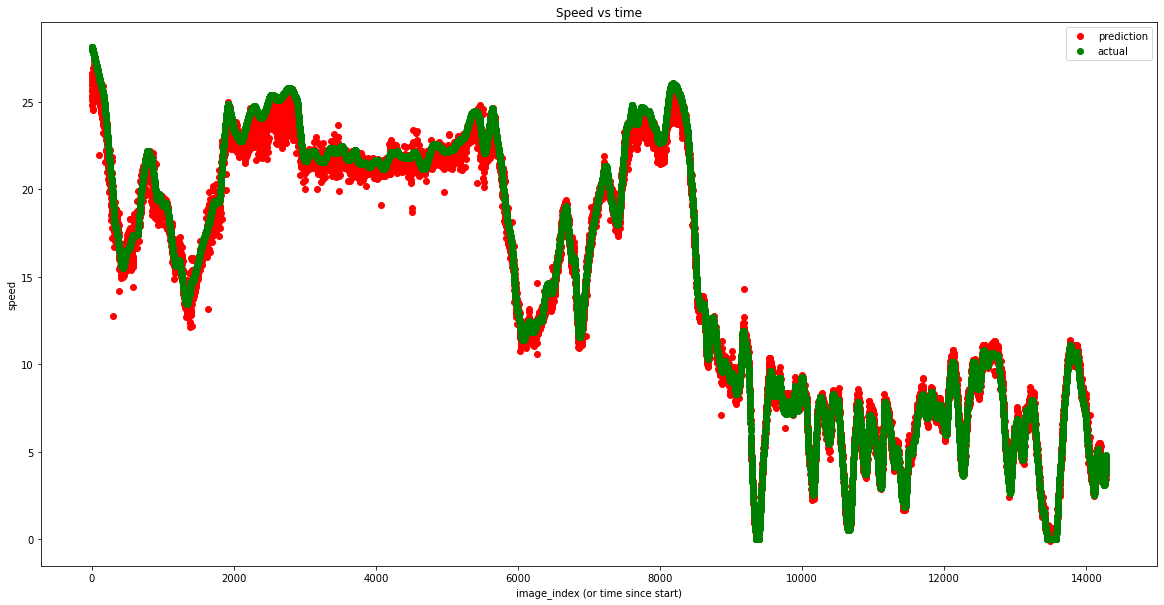

----


In [120]:
plot(train_ids, train_meta['speed'], preds)

In [121]:
model.eval()
preds = []
for j, data in enumerate(val_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

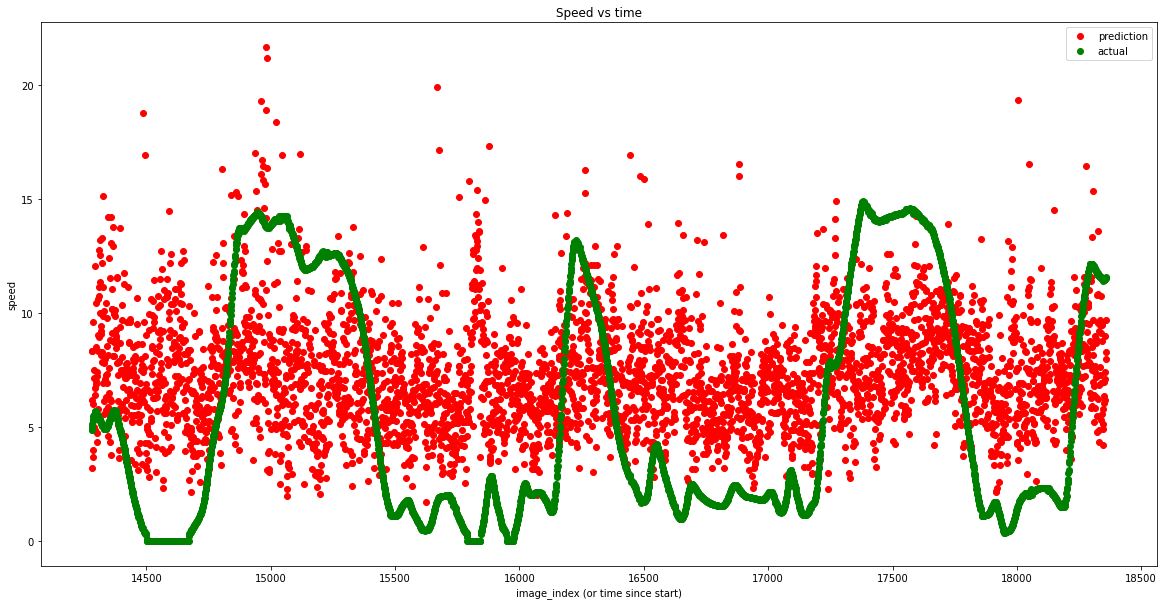

----


In [122]:
plot(val_ids, val_meta['speed'], preds)

### Holdout

In [123]:
holdout_flow = OpticalFlowDataset(HOLDOUT_PATH/'holdout_meta.csv', 
                                  HOLDOUT_PATH,
                                  overwrite_flow = True,
                                  pre_flow_transforms = transforms.Compose([Crop()]),
                                  post_flow_transforms = transforms.Compose([ToTensor(),
                                                                             transforms.Normalize(normalize_vals[0], 
                                                                                                  normalize_vals[1])
                                                                            ])
                             )

holdout_dataloader = DataLoader(holdout_flow, batch_size=batch_size, shuffle=False, num_workers=0)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
model.eval()
preds = []
for j, data in enumerate(holdout_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

In [ ]:
plot(holdout_ids, holdout_meta['speed'], preds)